In [3]:
%pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 20.4 MB/s eta 0:00:0000:0100:01
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from IPython.display import display
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [7]:
data = pd.read_csv("/Users/alana/Desktop/eth/FS23/data science/Project 8/diabetes.csv")
data.shape

(768, 9)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [10]:
display(data.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [11]:
data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [12]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Diabetes dataset

**Pregnancies:** # of pregnancies  
**Glucose:** Plasma glucose concentration over 2 hours in an oral glucose tolerance test  
**BloodPressure:** Diastolic blood pressure (mm Hg)  
**SkinThickness:** Triceps skin fold thickness (mm)  
**Insulin:** 2-Hour serum insulin ($\frac {U}{ml}$)  
**BMI:** Body mass index ($\frac{kg}{m^2}$)  
**DiabetesPedigreeFunction:** Diabetes pedigree function (a function which scores likelihood of diabetes based on family history)  
**Age:** Age (years)  
**Outcome:** Class variable (0 if non-diabetic, 1 if diabetic)

## Data visualization

First we want to check how many People in our Dataset are diabetic vs non-diabetic

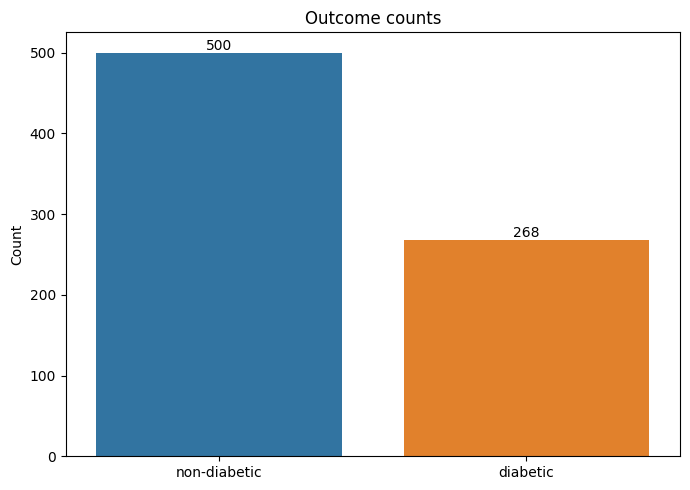

In [13]:
fig, ax = plt.subplots(figsize = (7,5))
outcome_count = data["Outcome"].value_counts()
outcome_count = pd.DataFrame(outcome_count)
outfig = sns.barplot(data = outcome_count, y = 'Outcome', x = outcome_count.index, ax = ax)
ax.set(ylabel = "Count", title = 'Outcome counts')
ax.set_xticklabels(["non-diabetic", 'diabetic'])
ax.bar_label(ax.containers[0], fmt='%.0f')
fig.tight_layout()

Our dataset is highly unbalanced...

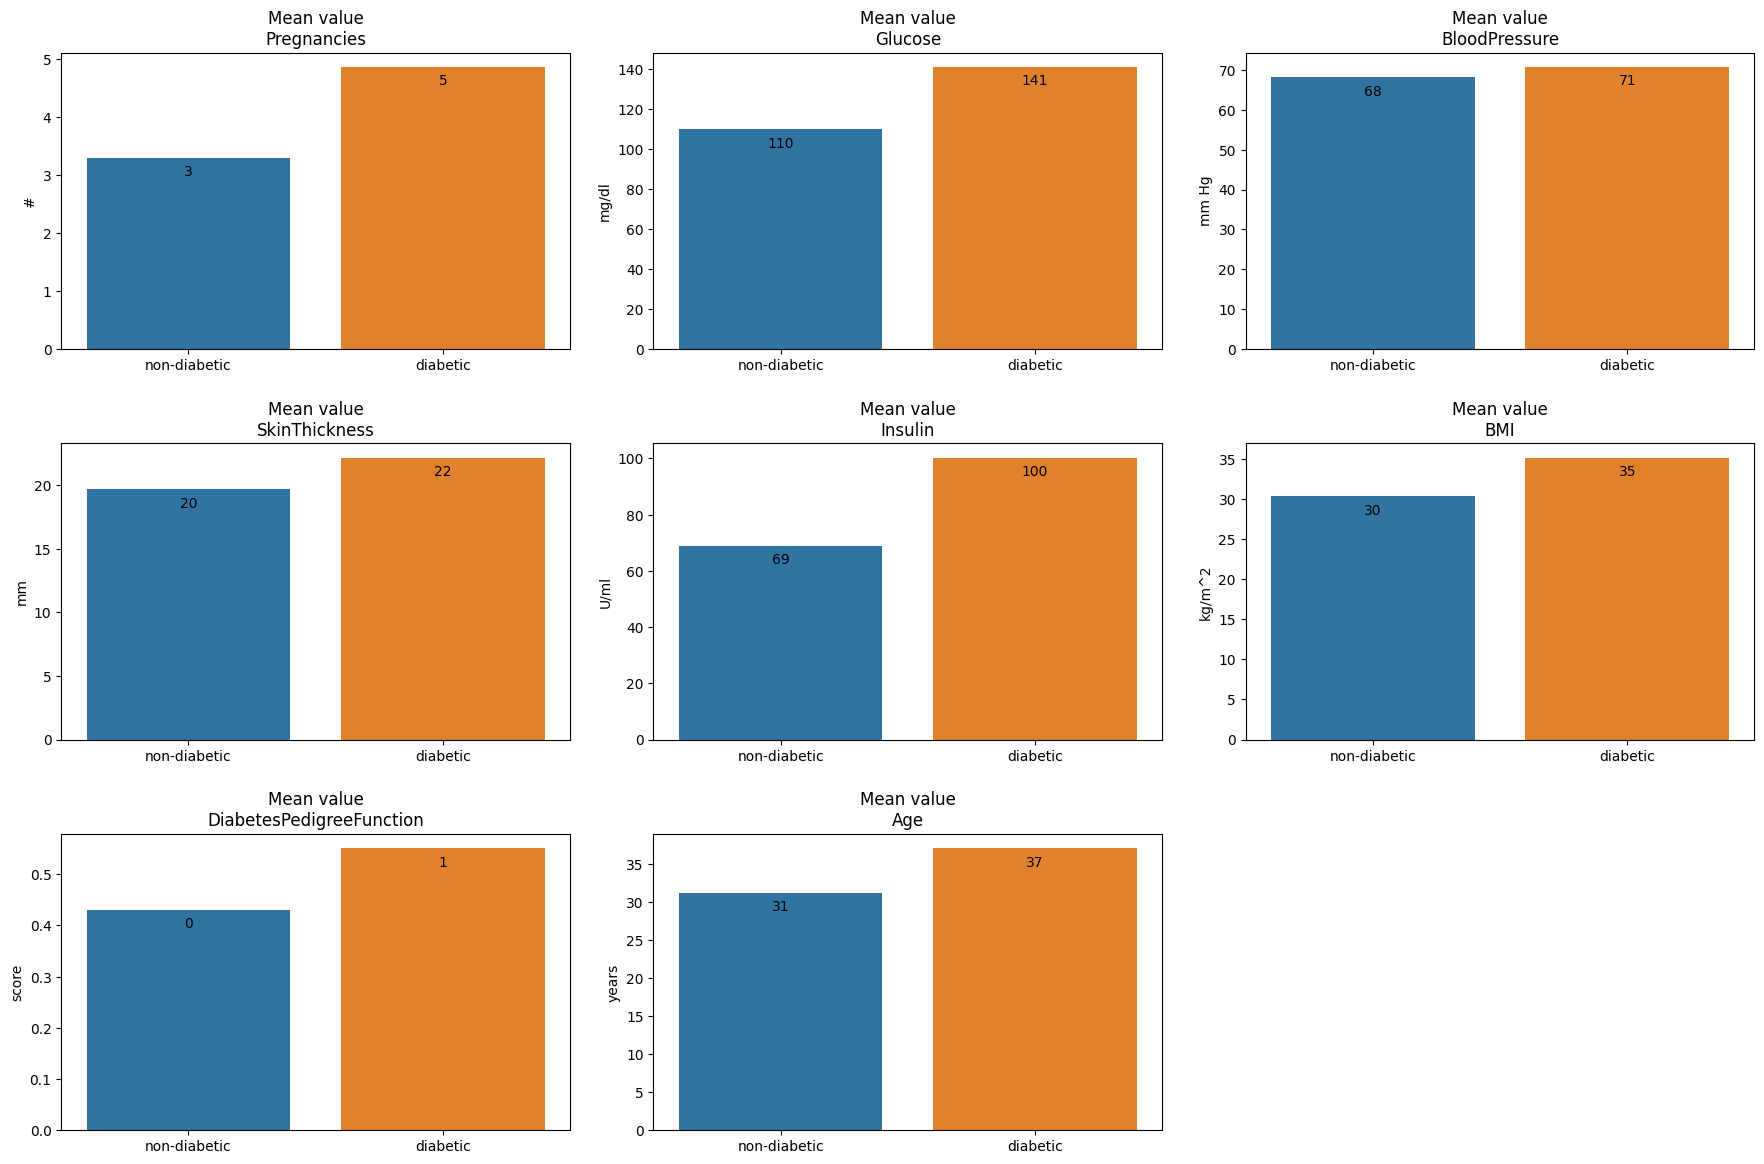

In [14]:
fig, ax = plt.subplots(3,3, figsize=(18,12))
fig.delaxes(ax.flatten()[-1])
units = ['#','mg/dl','mm Hg', 'mm', 'U/ml', 'kg/m^2', 'score', 'years']
for i, feature in enumerate(data.columns.drop('Outcome')):
    non_diab = np.mean(data[feature][data['Outcome'] == 0])
    diab = np.mean(data[feature][data['Outcome'] == 1])
    ok = [non_diab, diab]
    frame = pd.DataFrame(ok)
    plot = sns.barplot(x = frame.index, y = frame[0], ax = ax.flat[i])
    ax.flat[i].set(ylabel = units[i], title = 'Mean value\n{}'.format(feature))
    ax.flat[i].set_xticklabels(["non-diabetic", 'diabetic'])
    ax.flat[i].bar_label(ax.flat[i].containers[0], fmt='%.0f', padding = -15)
plt.tight_layout(pad = 2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


<Axes: >

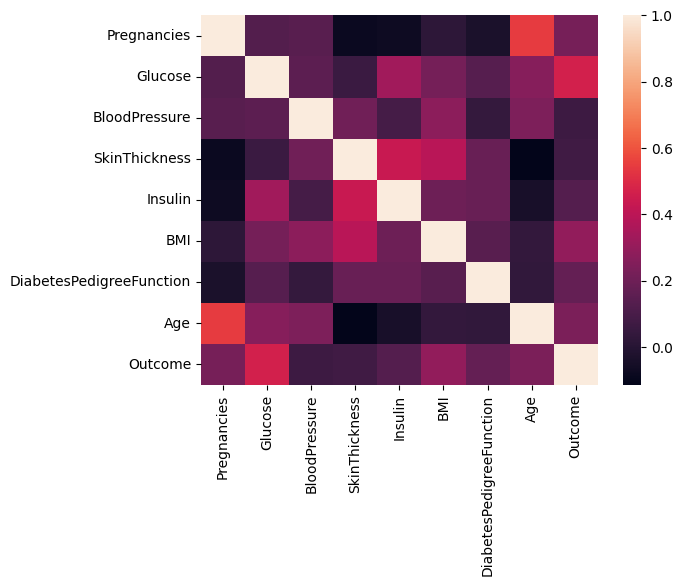

In [15]:
corr = data.corr()
display(corr)
sns.heatmap(corr, 
         xticklabels=corr.columns, 
         yticklabels=corr.columns)

In [16]:
num_columns = ['Pregnancies','Glucose','BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
cat_columns = ['Outcome']
data[cat_columns] = data[cat_columns].astype('category')

In [17]:
X = data[num_columns]
y = data[cat_columns]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2023,stratify=y
)

In [19]:
sc = StandardScaler()
X_train[num_columns] = sc.fit_transform(X_train[num_columns])
X_test[num_columns]  = sc.transform(X_test[num_columns])

In [20]:
clf_SVM = svm.SVC(probability=True, kernel = 'linear')
clf_SVM.fit(X_train, y_train)

clf_LR = LogisticRegression(random_state=1)
clf_LR.fit(X_train, y_train)

clf_RF = RandomForestClassifier(random_state=1)
clf_RF.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/4z/14ln7tgs60d0nncycr_92pf00000gp/T/ipykernel_7230/3487213248.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_RF.fit(X_train, y_train)


RandomForestClassifier(random_state=1)

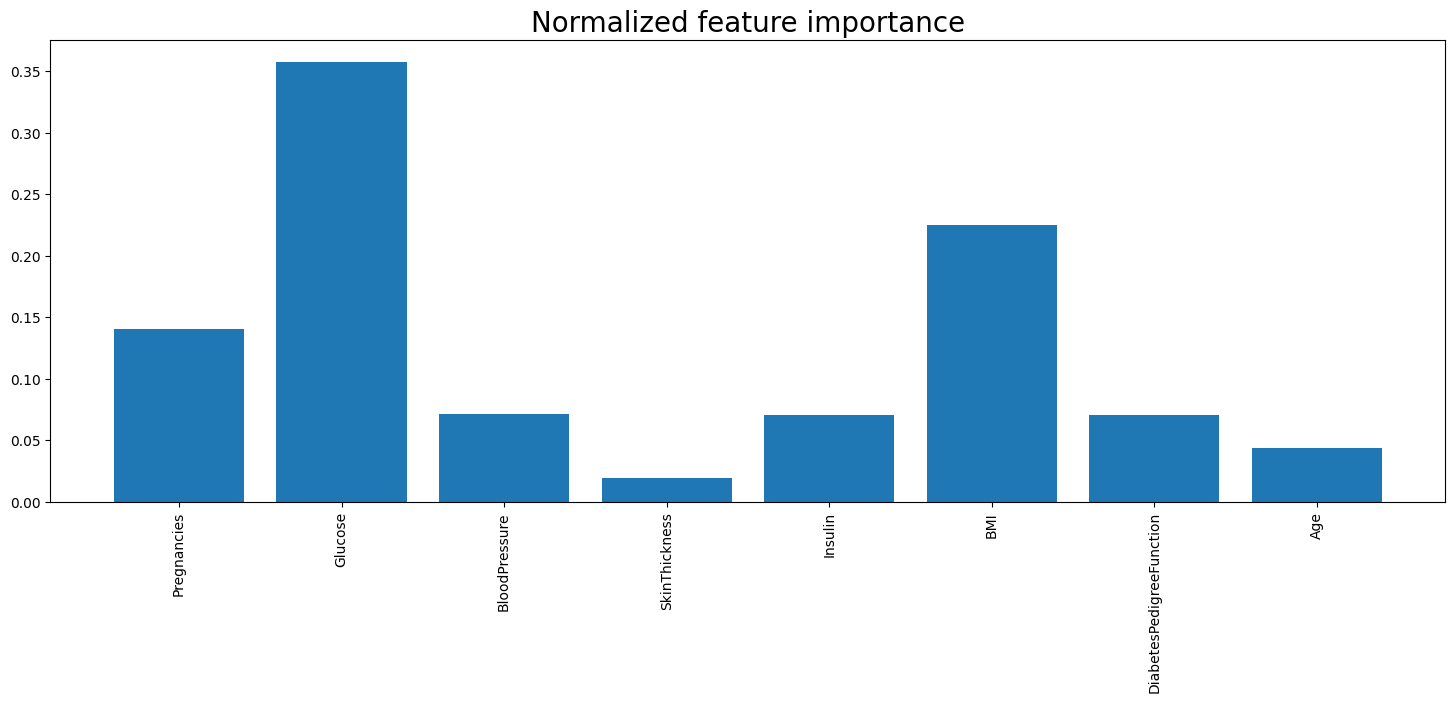

In [21]:
coefficients = clf_LR.coef_
importance = np.abs(coefficients)
# Normalize the absolute coefficients to obtain feature importance scores
importance_scores = (importance / np.sum(importance)).flatten()

fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(np.arange(len(importance_scores)), importance_scores)
ax.set_xticks(
    np.arange(len(importance_scores)), X.columns.tolist(), rotation=90
)  # set the xticks according to the feature names, and rotate them by 90 degrees
ax.set_title("Normalized feature importance", fontsize=20)
plt.show()

In [22]:
def eval_Performance(y_eval, X_eval, clf, clf_name = 'My Classifier'):

    y_pred = clf.predict(X_eval)
    y_pred_proba = clf.predict_proba(X_eval)[:, 1]
    tn, fp, fn, tp = confusion_matrix(y_eval, y_pred).ravel()

    # Evaluation
    accuracy  = accuracy_score(y_eval, y_pred)
    precision = precision_score(y_eval, y_pred)
    recall    = recall_score(y_eval, y_pred)
    f1        = f1_score(y_eval, y_pred)
    fp_rates, tp_rates, _ = roc_curve(y_eval, y_pred_proba)

    # Calculate the area under the roc curve using a sklearn function
    roc_auc = auc(fp_rates, tp_rates)

    return tp,fp,tn,fn,accuracy, precision, recall, f1, roc_auc

df_performance = pd.DataFrame(columns = ['tp','fp','tn','fn','accuracy', 'precision', 'recall', 'f1', 'roc_auc'] )
df_performance.loc['SVM (test)',:] = eval_Performance(y_test, X_test, clf_SVM, clf_name = 'SVM')
df_performance.loc['SVM (train)',:] = eval_Performance(y_train, X_train, clf_SVM, clf_name = 'SVM (train')

df_performance.loc['LR (test)',:] = eval_Performance(y_test, X_test, clf_LR, clf_name = 'LR')
df_performance.loc['LR (train)',:] = eval_Performance(y_train, X_train, clf_LR, clf_name = 'LR (train)')

df_performance.loc['RF (test)',:] = eval_Performance(y_test, X_test, clf_RF, clf_name = 'RF')
df_performance.loc['RF (train)',:] = eval_Performance(y_train, X_train, clf_RF, clf_name = 'RF (train)')

In [23]:
df_performance

,tp,fp,tn,fn,accuracy,precision,recall,f1,roc_auc
SVM (test),34,12,88,20,0.792208,0.73913,0.62963,0.68,0.853704
SVM (train),118,41,359,96,0.776873,0.742138,0.551402,0.632708,0.833324
LR (test),35,12,88,19,0.798701,0.744681,0.648148,0.693069,0.852963
LR (train),118,42,358,96,0.775244,0.7375,0.551402,0.631016,0.833119
RF (test),30,12,88,24,0.766234,0.714286,0.555556,0.625,0.830556
RF (train),214,0,400,0,1.0,1.0,1.0,1.0,1.0


In [24]:
data_encoded = pd.get_dummies(data, drop_first=True)
X = data_encoded.drop('Outcome_1',axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023,stratify=y)
sc = StandardScaler()
X_train[num_columns] = sc.fit_transform(X_train[num_columns])
X_test[num_columns]  = sc.transform(X_test[num_columns])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


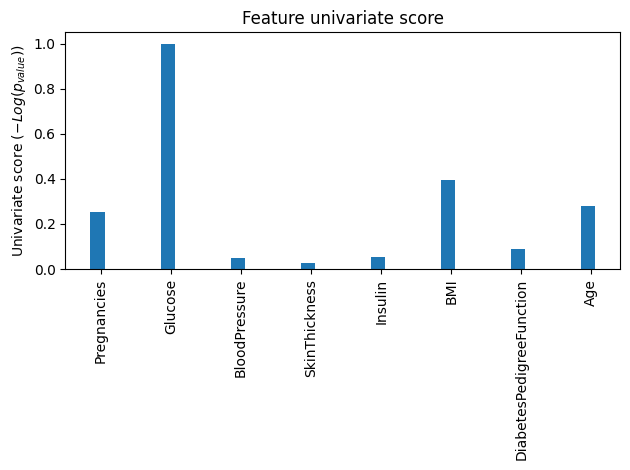

In [25]:
UVFS_Selector = SelectKBest(f_classif, k=4) # Select top 4 features
X_UVFS = UVFS_Selector.fit_transform(X_train, y_train) # ...but only on training data.
X_UVFS_test = UVFS_Selector.transform(X_test)
scores = -np.log10(UVFS_Selector.pvalues_)
scores /= scores.max()

# Plot 
X_indices = np.arange(X.shape[-1])
plt.figure()
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.xticks(X_indices, X.columns, rotation = 90)
plt.tight_layout()
plt.show()

In [26]:
clf_LR_bal_FS = LogisticRegression(random_state=1, class_weight='balanced')
clf_LR_bal_FS.fit(X_UVFS, y_train)

# Evaluation
df_performance.loc['LR (test,bal,UVFS)',:] = eval_Performance(y_test, X_UVFS_test, clf_LR_bal_FS, clf_name = 'LR_bal_UVFS')
df_performance.loc['LR (train,bal,UVFS)',:] = eval_Performance(y_train, X_UVFS, clf_LR_bal_FS, clf_name = 'LR_bal_UVFS (train)')
df_performance

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,tp,fp,tn,fn,accuracy,precision,recall,f1,roc_auc
SVM (test),34,12,88,20,0.792208,0.73913,0.62963,0.68,0.853704
SVM (train),118,41,359,96,0.776873,0.742138,0.551402,0.632708,0.833324
LR (test),35,12,88,19,0.798701,0.744681,0.648148,0.693069,0.852963
LR (train),118,42,358,96,0.775244,0.7375,0.551402,0.631016,0.833119
RF (test),30,12,88,24,0.766234,0.714286,0.555556,0.625,0.830556
RF (train),214,0,400,0,1.0,1.0,1.0,1.0,1.0
"LR (test,bal,UVFS)",41,27,73,13,0.74026,0.602941,0.759259,0.672131,0.839444
"LR (train,bal,UVFS)",154,98,302,60,0.742671,0.611111,0.719626,0.660944,0.822909
